In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
sns.set(style="whitegrid", color_codes=True)
%matplotlib inline

In [18]:
data = pd.read_csv('/home/artem/Projects/wolf_of_crunchbase/data/transformed_data.csv')

<H3>Columns in data file</H3>

In [3]:
data.columns

Index(['company_id', 'category_code', 'country_code', 'state_code', 'city',
       'region', 'ipo', 'is_acquired', 'is_closed', 'age', 'mba_degree',
       'phd_degree', 'ms_degree', 'other_degree', 'offices',
       'average_raised_amount_usd', 'average_participants', 'total_rounds',
       'products_number'],
      dtype='object')

In [4]:
print("Total companies: ", data.shape[0])
print("Total features: ", data.shape[1])
print("Share of acquired companies: ", data.is_acquired.mean())

Total companies:  31661
Total features:  19
Share of acquired companies:  0.0830674962888


<H3>Testing data assumption</H3>


Columns 'age' and 'category_code' seem as important features. Let's test this assumption.

<H4>Probability of company acquisition depending on age (splitting by five years)</H4>
Also count of companies of each age is located below.

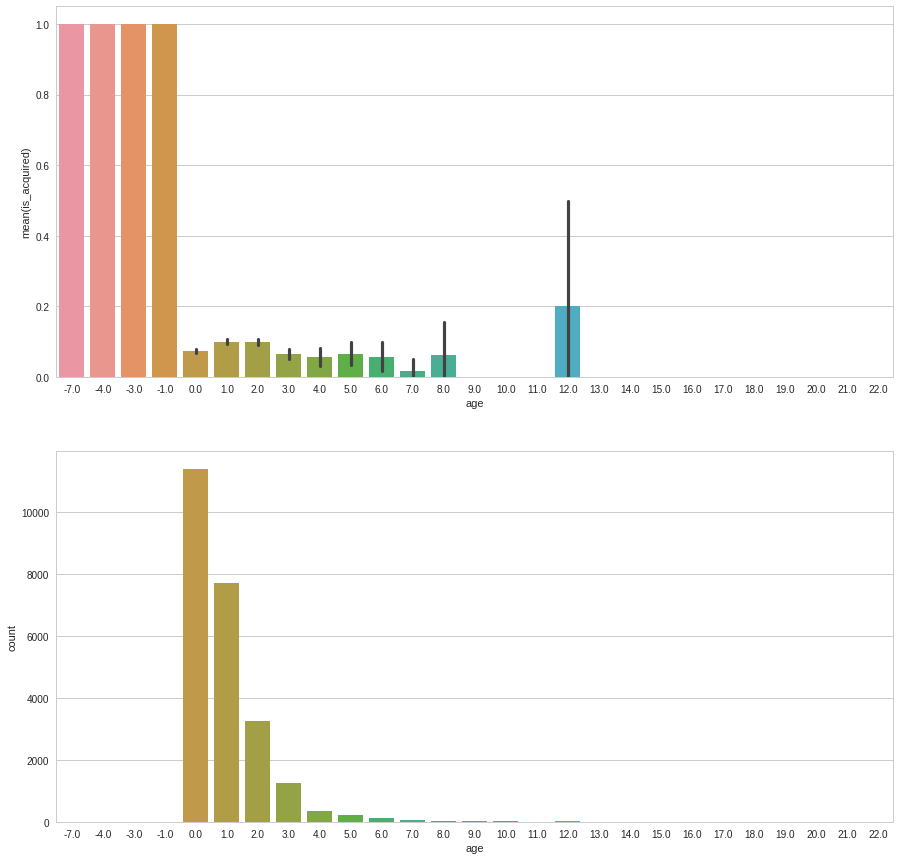

In [5]:
age_acquisition = pd.DataFrame({'age': data.age.apply(lambda x: x // (365 * 5))})
age_acquisition['is_acquired'] = data.is_acquired
fig, axs = plt.subplots(2, 1, figsize=(15,15))
sns.barplot(x='age', y='is_acquired', data=age_acquisition, ax=axs[0])
sns.countplot(x='age', data=age_acquisition[age_acquisition['age'].notnull()], ax=axs[1])

As we can see, there is some mistakes in data: age of several companies is negative. Let's rid off it.

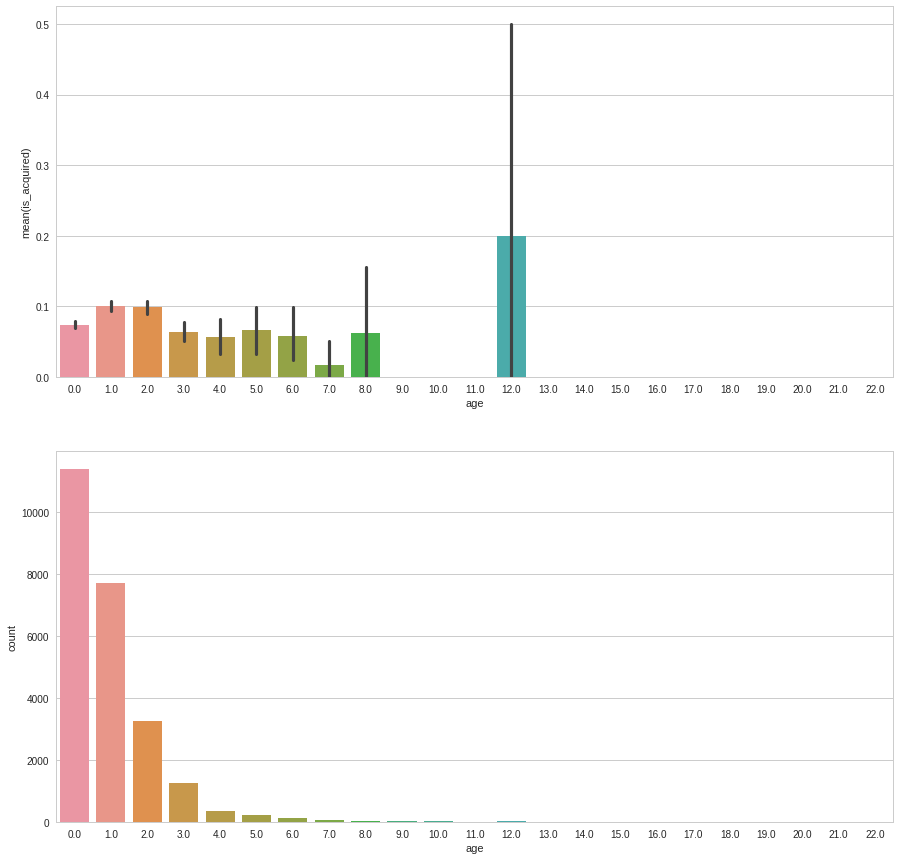

In [19]:
data = data[data.age >= 0 | data.age.isnull()]
age_acquisition = pd.DataFrame({'age': data.age.apply(lambda x: x // (365 * 5))})
age_acquisition['is_acquired'] = data.is_acquired
fig, axs = plt.subplots(2, 1, figsize=(15,15))
sns.barplot(x='age', y='is_acquired', data=age_acquisition, ax=axs[0])
sns.countplot(x='age', data=age_acquisition[age_acquisition['age'].notnull()], ax=axs[1])

It seems like probability of company acquisition grows up till second decade of company life and falls after reaching it.

<H4>Probability of company acquisition depending on company category</H4>

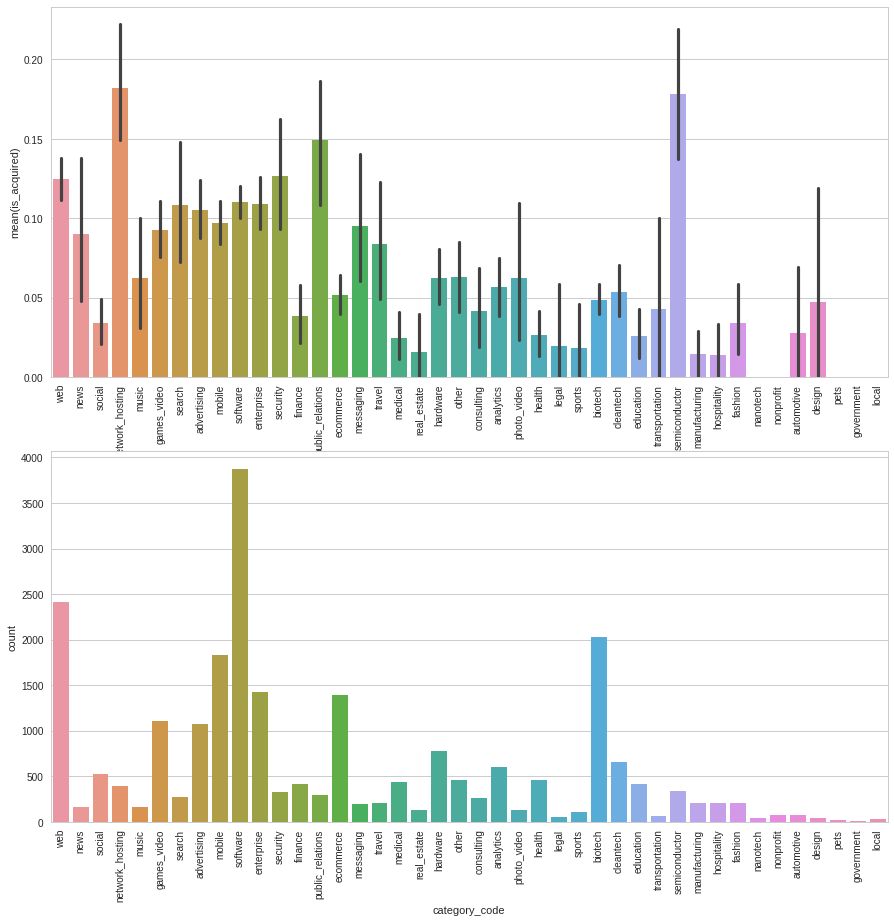

In [7]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))
p1 = sns.barplot(x='category_code', y='is_acquired', data=data, ax=axs[0])
p2 = sns.countplot(x='category_code', data=data, ax=axs[1])
for plot in [p1, p2]:
    for item in plot.get_xticklabels():
        item.set_rotation(90)

In [8]:
data.groupby(by='category_code').is_acquired.mean().sort_values(ascending=False)

category_code
network_hosting     0.181818
semiconductor       0.178363
public_relations    0.149153
security            0.126506
web                 0.124897
software            0.110509
enterprise          0.108848
search              0.108303
advertising         0.105509
mobile              0.097321
messaging           0.095477
games_video         0.092626
news                0.089820
travel              0.083744
other               0.063043
hardware            0.062580
music               0.062500
photo_video         0.062500
analytics           0.056761
cleantech           0.053517
ecommerce           0.051502
biotech             0.048889
design              0.047619
transportation      0.042857
consulting          0.041825
finance             0.038554
fashion             0.034314
social              0.034156
automotive          0.027778
health              0.026258
education           0.026190
medical             0.024887
legal               0.019608
sports              0.018519


Based on data shown above we can conclude that companes of certain categories can be acquired with higher probability than others.

<H4>Correlation between columns</H4>

In [9]:
corrmat = data[data.dtypes[data.dtypes == np.float64].index].corr()
corrmat

,age,mba_degree,phd_degree,ms_degree,other_degree,offices,average_raised_amount_usd,average_participants,products_number
age,1.000000,0.158319,0.163349,0.154671,0.157436,0.015802,0.164733,-0.007930,0.148710
mba_degree,0.158319,1.000000,0.684928,0.873890,0.939977,0.313210,0.186462,0.023315,0.575757
phd_degree,0.163349,0.684928,1.000000,0.737951,0.730530,0.409808,0.130877,0.011736,0.825573
ms_degree,0.154671,0.873890,0.737951,1.000000,0.918636,0.425202,0.117035,0.001166,0.695108
other_degree,0.157436,0.939977,0.730530,0.918636,1.000000,0.342763,0.131383,0.051925,0.574780
offices,0.015802,0.313210,0.409808,0.425202,0.342763,1.000000,0.021640,0.030985,0.449583
average_raised_amount_usd,0.164733,0.186462,0.130877,0.117035,0.131383,0.021640,1.000000,0.049625,0.073412
average_participants,-0.007930,0.023315,0.011736,0.001166,0.051925,0.030985,0.049625,1.000000,-0.005260
products_number,0.148710,0.575757,0.825573,0.695108,0.574780,0.449583,0.073412,-0.005260,1.000000


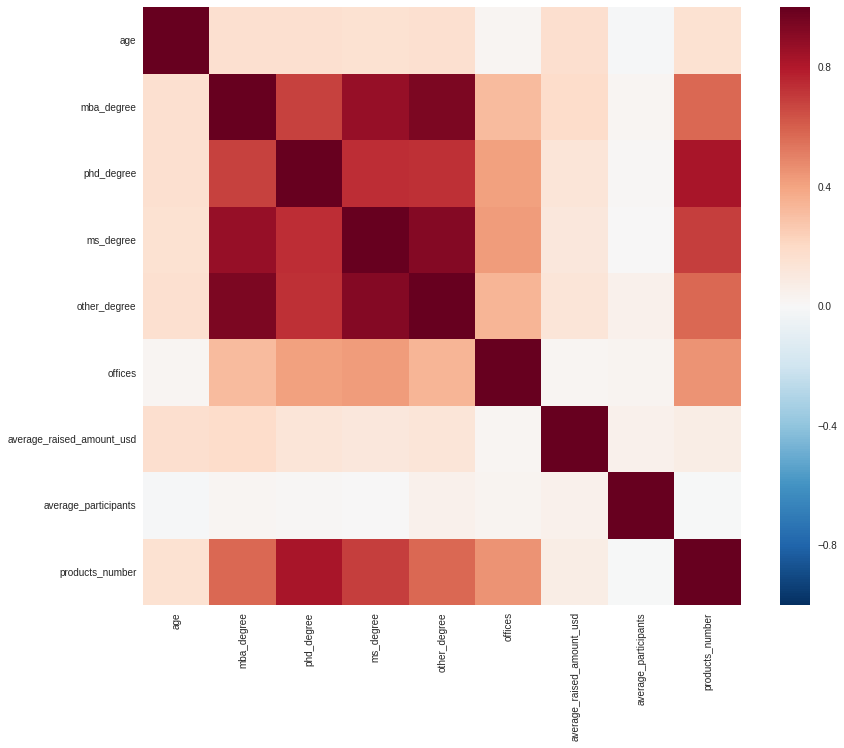

In [10]:
f, ax = plt.subplots(figsize=(14, 11))
sns.heatmap(corrmat, vmax=1, square=True);

It is obvious that degree columns will correlate with each other, because they relate with general concept "number of people". Also there is no questions why number of products correlate with number of people.

<H4> Pairwise data distribution</H4>

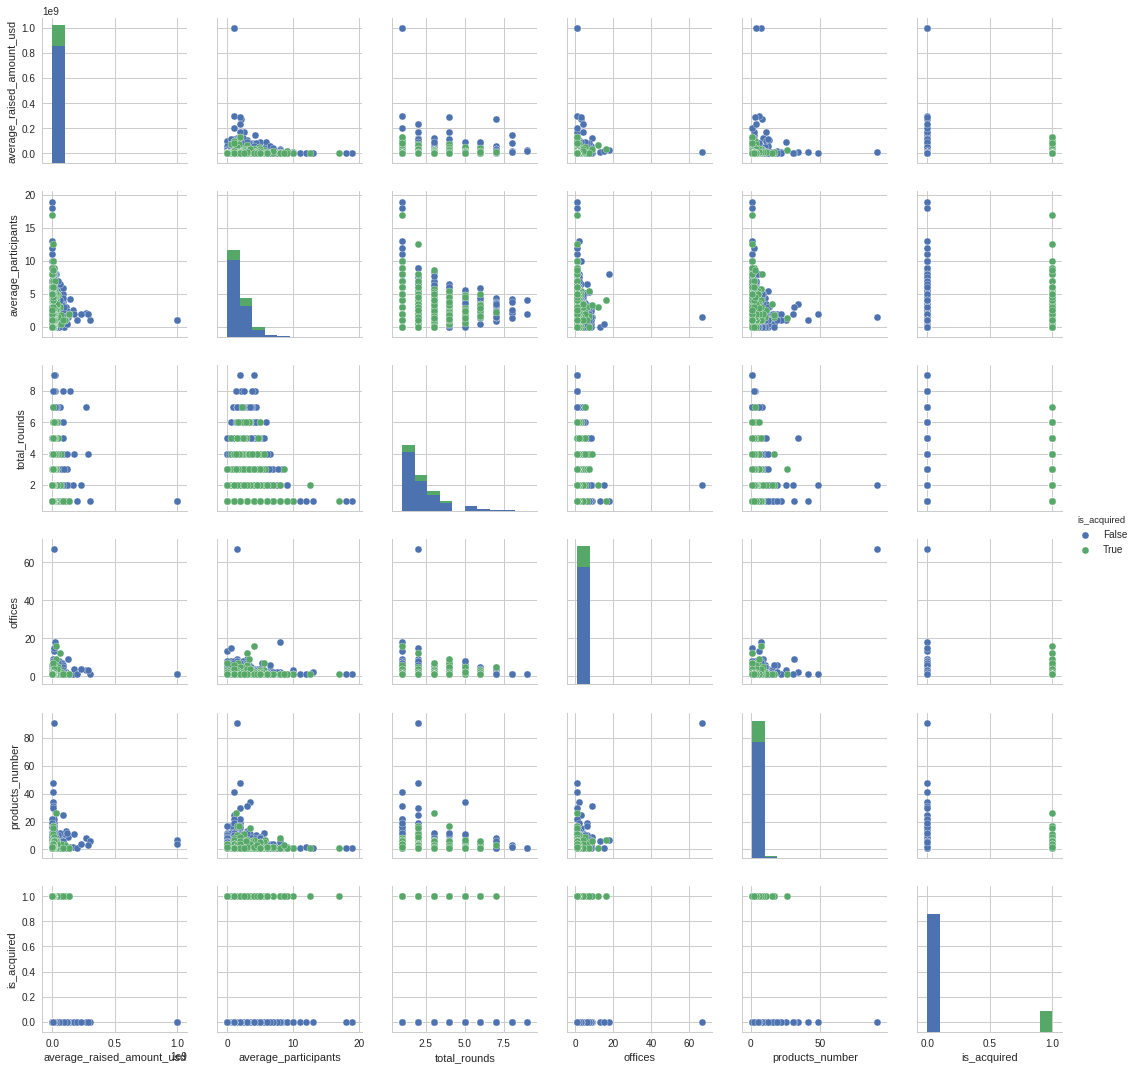

In [12]:
economic_columns = ['average_raised_amount_usd', 'average_participants', 'total_rounds', 'offices', 'products_number']
columns = economic_columns + ['is_acquired']
investment_info = data[data[columns].notnull().all(axis=1)][columns]
sns.pairplot(investment_info, hue='is_acquired')

It is difficult to say something concrete about data distribution based on pairplot shown above, but it seems like companies got acquired have less economic succesfullness.

<H3>Data preparation</H3>

<H4>Filling missing values</H4>

Fullness of columns:

In [20]:
data.notnull().mean()

company_id                   1.000000
category_code                0.980346
country_code                 0.954181
state_code                   0.642740
city                         0.929776
region                       1.000000
ipo                          1.000000
is_acquired                  1.000000
is_closed                    1.000000
age                          1.000000
mba_degree                   0.286586
phd_degree                   0.094955
ms_degree                    0.217591
other_degree                 0.533249
offices                      0.954181
average_raised_amount_usd    0.886332
average_participants         1.000000
total_rounds                 1.000000
products_number              0.152117
dtype: float64

Filling degree columns:

In [21]:
degree_columns = ['mba_degree', 'phd_degree', 'ms_degree', 'other_degree']
data.loc[:,degree_columns] = data[degree_columns].fillna(0)

In [22]:
data[degree_columns].head(10)

,mba_degree,phd_degree,ms_degree,other_degree
0,5.0,1.0,3.0,18.0
1,7.0,2.0,5.0,47.0
2,44.0,4.0,47.0,238.0
3,0.0,0.0,1.0,1.0
4,0.0,0.0,0.0,10.0
5,18.0,10.0,11.0,116.0
6,3.0,0.0,5.0,30.0
7,3.0,0.0,5.0,30.0
8,0.0,0.0,0.0,0.0
9,4.0,0.0,1.0,14.0


In [25]:
selection = data.average_participants == 0.0
data.loc[selection, 'average_raised_amount_usd'] = data.loc[selection, 'average_raised_amount_usd'].fillna(0)

In [26]:
data.notnull().mean()

company_id                   1.000000
category_code                0.980346
country_code                 0.954181
state_code                   0.642740
city                         0.929776
region                       1.000000
ipo                          1.000000
is_acquired                  1.000000
is_closed                    1.000000
age                          1.000000
mba_degree                   1.000000
phd_degree                   1.000000
ms_degree                    1.000000
other_degree                 1.000000
offices                      0.954181
average_raised_amount_usd    0.914831
average_participants         1.000000
total_rounds                 1.000000
products_number              0.152117
dtype: float64